<a href="https://colab.research.google.com/github/twyeh/highenergy/blob/main/C7_C7p_constraints_1608_02556.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flavio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.8/594.8 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
  Created wheel for parton: filename=parton-0.2.2-py3-none-any.whl size=14000 sha256=3dd00cb8c305fd5d15132698114f831302fed5a84c0e113e88ab22e5296d7f64
  Stored in directory: /root/.cache/pip/wheels/4f/5f/ba/4a4c454a28005125067382ffc0c3e967429b658917d062d75e
  Created wheel for pylha: filename=pylha-0.4-py3-none-any.whl size=58269 sha256=818e1d088d8629a18f22833bbeb1b23f65fc92ac4a08c69e721740333b6e5730
  Stored in directory: /root/.cache/pip/wheels/e5/fa/51/6cb033ac4cb2857410fa6e15c87a4501df116007d79c91b473
Successfully

# Constraints on $C_7$ and $C_7'$

This notebook generates the Wilson coefficient plots of the paper [arXiv:1608.02556](https://arxiv.org/abs/1608.02556) by Ayan Paul and David M. Straub. It uses [flavio](https://flav-io.github.io/) v0.20.

## Preliminaries

Loading packages

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import flavio
import flavio.plots
import flavio.statistics
import matplotlib.pyplot as plt
from collections import OrderedDict

Load the LCSR-only $B\to V$ form factors from [arXiv:1503.05534](https://arxiv.org/abs/1503.05534) (instead of the combined LCSR-LQCD fit used by default; see appendix A)

In [4]:
flavio.physics.bdecays.formfactors.b_v.bsz_parameters.bsz_load_v2_lcsr(flavio.default_parameters)

Relevant observables

In [5]:
observables = [
  'BR(B+->K*gamma)',
  'BR(B->Xsgamma)',
  'BR(B0->K*gamma)',
  'BR(Bs->phigamma)',
  'ADeltaGamma(Bs->phigamma)',
  'S_K*gamma',
  ('<ATIm>(B0->K*ee)', 0.002, 1.12),
  ('<P1>(B0->K*ee)', 0.002, 1.12),
]

## Setting up the fits

Defining the `FastFit` instances for a given Wilson coefficient scenario and observable set. See [the documentation](https://flav-io.github.io/docs/fits.html) for details.

In [6]:
def wc_fct(C7Re, C7Im, C7pRe, C7pIm):
    return { 'C7eff_bs': C7Re + 1j * C7Im, 'C7effp_bs': C7pRe + 1j * C7pIm }

In [7]:
def fastfit_obs(name, obslist):
    return flavio.statistics.fits.FastFit(
                name = name,
                nuisance_parameters = [p for p in flavio.default_parameters.all_parameters if p not in ['alpha_s', 'alpha_e', 'm_Z']],
                observables = obslist,
                fit_wc_function = wc_fct,
                input_scale = 4.8,
            )

In [8]:
fits = OrderedDict()
fits['BR'] = ['BR(B+->K*gamma)', 'BR(B->Xsgamma)', 'BR(B0->K*gamma)', 'BR(Bs->phigamma)',]
fits['A'] = ['ADeltaGamma(Bs->phigamma)']
fits['P1'] = [('<P1>(B0->K*ee)', 0.002, 1.12)]
fits['S'] = ['S_K*gamma']
fits['ATIm'] = [('<ATIm>(B0->K*ee)', 0.002, 1.12)]

In [9]:
labels = {
    'BR': 'branching ratios',
    'A': flavio.Observable.get_instance(fits['A'][0]).tex,
    'S': flavio.Observable.get_instance(fits['S'][0]).tex,
    'ATIm': flavio.Observable.get_instance(fits['ATIm'][0][0]).tex,
    'P1': flavio.Observable.get_instance(fits['P1'][0][0]).tex,
}

Generating the pseudo measurements for all the fits.

In [10]:
%%time
obs_fastfits={}
for k, v in fits.items():
    obs_fastfits[k] = fastfit_obs('C7-C7p fit '+ k, v)
    obs_fastfits[k].make_measurement(N=200, threads=4)

AttributeError: module 'flavio.statistics' has no attribute 'fits'

In [ ]:
%%time
global_fastfit = fastfit_obs('C7-C7p fit global', observables)
global_fastfit.make_measurement(N=200, threads=4)

CPU times: user 696 ms, sys: 136 ms, total: 832 ms
Wall time: 10.4 s


## Results

CPU times: user 232 ms, sys: 168 ms, total: 400 ms
Wall time: 30 s


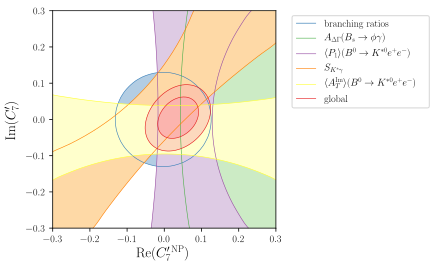

In [ ]:
%%time
fig=plt.figure(figsize=(4,4))
x_max=0.33
plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])
for i, f in enumerate(fits):
    def ll(x): # log likelihood for Re, Im C7'
        return obs_fastfits[f].log_likelihood([0, 0, x[0], x[1]])
    flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=1, col=i+1, label=labels[f],
                        interpolation_factor=3, threads=4)
def ll(x): # log likelihood for Re, Im C7'
    return global_fastfit.log_likelihood([0, 0, x[0], x[1]])
flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=(1, 2), col=0,
                       interpolation_factor=10, threads=4, label='global')

# labels, legend
plt.xlabel(r'$\text{Re}(C_7^{\prime\,\text{NP}})$')
plt.ylabel(r'$\text{Im}(C_7^\prime)$')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

CPU times: user 512 ms, sys: 344 ms, total: 856 ms
Wall time: 1min 12s


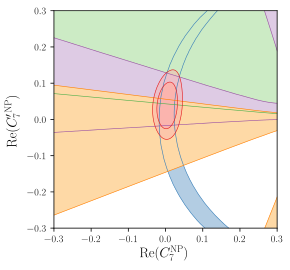

In [ ]:
%%time
fig2=plt.figure(figsize=(4,4))
x_max=0.36
plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])
for i, f in enumerate(fits):
    if f == 'ATIm':
        continue # no need to plot ATIm
    def ll(x): # log likelihood for Re C7, Re C7'
        return obs_fastfits[f].log_likelihood([x[0], 0, x[1], 0])
    flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=1, col=i+1, interpolation_factor=3, steps=30, threads=4)
def ll(x): # log likelihood for Re C7, Re C7'
    return global_fastfit.log_likelihood([x[0], 0, x[1], 0])
flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=(1,2),
                       col=0, interpolation_factor=10, threads=4)

# labels
plt.xlabel(r'$\text{Re}(C_7^\text{NP})$')
plt.ylabel(r'$\text{Re}(C_7^{\prime\,\text{NP}})$')